## BCG/Bovis regions

In [1]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting, rdiff
import toytree, toyplot

In [2]:
meta=pd.read_csv('metadata.csv')

In [ ]:
reload(app)
args = {'threads':12,'outdir': 'results_mtb', 'labelsep':'_',
        'input':['data'],
         'species': 'MTB-H37Rv', #'Mbovis-AF212297',
         'overwrite':False,'unmapped':True,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [3]:
samples=pd.read_csv('results_mtb/samples.csv')
samples=samples.merge(meta,left_on='sample',right_on='name')
mapdict=dict(zip(meta.name,meta.strain))
samples['strain'] = samples['sample'].map(mapdict)

In [4]:
treefile = 'results_mtb/tree.newick'
tre = toytree.tree(treefile)
#tre = tre.root('ref')
tre = tre.drop_tips('ref')
canvas,t,r=tre.draw(height=400,width=800)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="400.0px" viewBox="0 0 800.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t84aaf658dd444741addbb99865105e55"> SRR3745458 39-MBovis 59-6110 cat-003488 dog-1034 TB19-007986 049-2005-NI ERR400386 ERR766266 ERR766251 ERR766254 ERR766257 SRR7983756 ERR552526 ERR027294

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


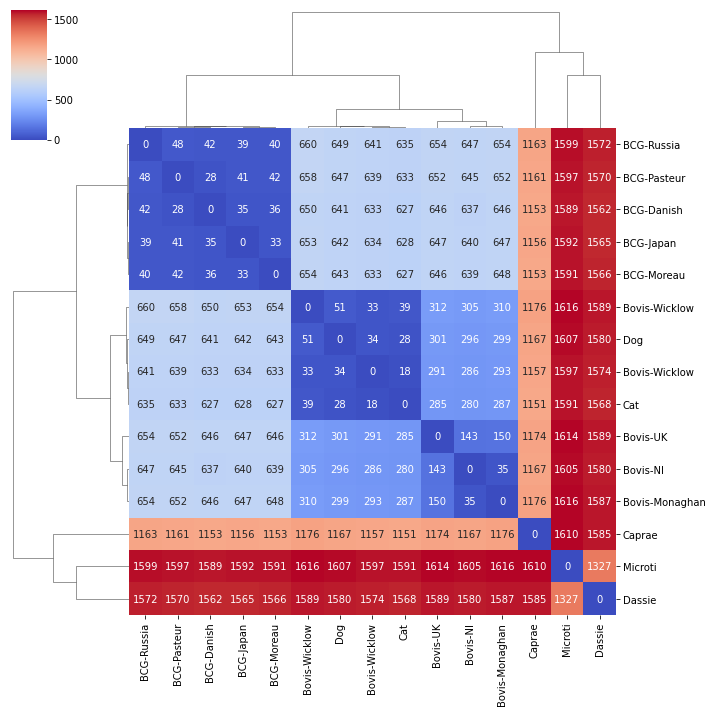

In [5]:
mat=pd.read_csv('results_mtb/snpdist.csv',index_col=0)
mat.index=mat.index.map(mapdict)
mat.columns=mat.columns.map(mapdict)
g=sns.clustermap(mat,annot=True,cmap='coolwarm',fmt='g')
#mat.style.background_gradient(cmap='coolwarm')

In [ ]:
clnames = g.data2d.index

## rd analysis

In [ ]:
from snipgenie import rdiff
rdiff.create_rd_index()
samples = pd.read_csv('results_mtb/samples.csv')
res = rdiff.run_samples(samples,'results/rd_aligned',threads=20)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
X.to_csv('rd.csv')

<AxesSubplot:ylabel='name'>

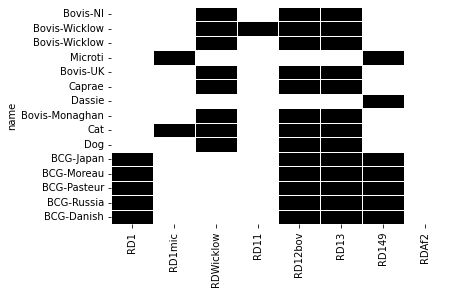

In [8]:
X=pd.read_csv('rd.csv',index_col=0)
X.index=X.index.map(mapdict)
x=X.iloc[:,:-1]
#cols=x.columns[(x.sum()<13) & (x.sum()>0)]
cols = ['RD1','RD1mic','RDWicklow','RD11','RD12bov','RD13','RD149','RDAf2']
sns.heatmap(x[cols],lw=1,ec='b',cbar=False,cmap='gray_r')

In [ ]:
X=pd.read_csv('rd.csv',index_col=0)
final=meta.merge(X[cols],left_on='name',right_index=True)
final.to_csv('final.csv',index=False)

In [7]:
#spo = tools.get_spoligotypes(samples)
#spo.to_csv('spoligotypes.csv')

In [6]:
rec = list(SeqIO.parse(app.mtb_gb,format='gb'))[0]
rec.features = [f for f in rec.features if f.type!='gene']

In [8]:
rd = pd.read_csv('/home/farrell/gitprojects/snipgenie/snipgenie/data/RD.csv')
print(rd[:10])#.sort_values('Start')

   RD_name    Start     Stop   Size            Rv
0    RD711  1501713  1503655   1943   Rv1333-1336
1    RD702   216795   218516   1722        Rv0186
2   RD1bcg  4349600  4359000   9400  Rv3871-3879c
3   RD1mic  4340400  4353500  13100   Rv3864-3871
4  RD2seal  2221000  2222900   1901  Rv1978-1979c
5   RD2bcg  2221100  2231800  10701   Rv1978-1988
6  RD12bov  3484700  3487500   2801   Rv3117-3121
7  RD12can  3479400  3491800  12401  Rv3111-3126c
8    RD105    79567    83034   3468   Rv0071-0074
9    RD239  4092077  4092919    843        Rv3651


## auto detect missing regions by binned intervals

In [6]:
a=np.zeros(1)
for i in range(3):
    x=np.random.randint(1,300,10)
    y=np.zeros(np.random.randint(10,20))
    a=np.concatenate([a,x,y])

def detect_deletions(df, thresh=2):
    """Detect regions of zero coverage"""
    
    a = df.coverage
    #print (a)
    p=df.pos.iloc[0]
    m = np.concatenate(( [True], a>thresh, [True] )) 
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)
    #print(ss)
    if len(ss)==0:
        return
    start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]
    ss = pd.DataFrame(ss,columns=['start','end'])
    ss = ss+p
    ss['length'] = ss.end-ss.start
    ss = ss[ss.length>1]
    ss = ss.sort_values('length',ascending=False)
    return ss

df = pd.DataFrame({'pos': np.arange(len(a))+10,'coverage':a})
detect_deletions(df)


,start,end,length
2,46,63,17
1,21,36,15
4,73,83,10


In [ ]:
bam_file='results_mtb/mapped/ERR400386.bam'
bam_file='results_mtb/mapped/049-2005-NI.bam'
s=2626400;e=s+12000
reload(rdiff)
df = rdiff._get_coverage(bam_file,'NC_000962.3',s,e,app.mtb_genome)
df.plot(x='pos',y='coverage',figsize=(20,3))
ss=detect_deletions(df,thresh=3)
print (ss)


In [ ]:
for t in range(0,4):
    df = rdiff.get_coverage(bam_file,'NC_000962.3',1,2411532,app.mtb_genome,minq=10,n_cores=12)
    ss = detect_deletions(df,thresh=t)
    print (t,len(ss))

0 115
1 141
2 173
3 197


## get deletions for all samples

In [28]:
reload(rdiff)
s = samples[samples.strain!='Bovis-UK']
regions = rdiff.get_deletions(s, app.mtb_genome, app.mtb_gb, 
                              label='strain', mask_file='mask.bed', n_cores=12)
regions.to_csv('deletion_regions.csv',index=False)

/storage/bcg_cat/results_mtb/mapped/049-2005-NI.bam
/storage/bcg_cat/results_mtb/mapped/39-MBovis.bam
/storage/bcg_cat/results_mtb/mapped/59-6110.bam
/storage/bcg_cat/results_mtb/mapped/ERR027294.bam
/storage/bcg_cat/results_mtb/mapped/ERR552526.bam
/storage/bcg_cat/results_mtb/mapped/ERR766251.bam
/storage/bcg_cat/results_mtb/mapped/ERR766254.bam
/storage/bcg_cat/results_mtb/mapped/ERR766257.bam
/storage/bcg_cat/results_mtb/mapped/ERR766266.bam
/storage/bcg_cat/results_mtb/mapped/SRR3745458.bam
/storage/bcg_cat/results_mtb/mapped/SRR7983756.bam
/storage/bcg_cat/results_mtb/mapped/TB19-007986.bam
/storage/bcg_cat/results_mtb/mapped/cat-003488.bam
/storage/bcg_cat/results_mtb/mapped/dog-1034.bam
3587
1263


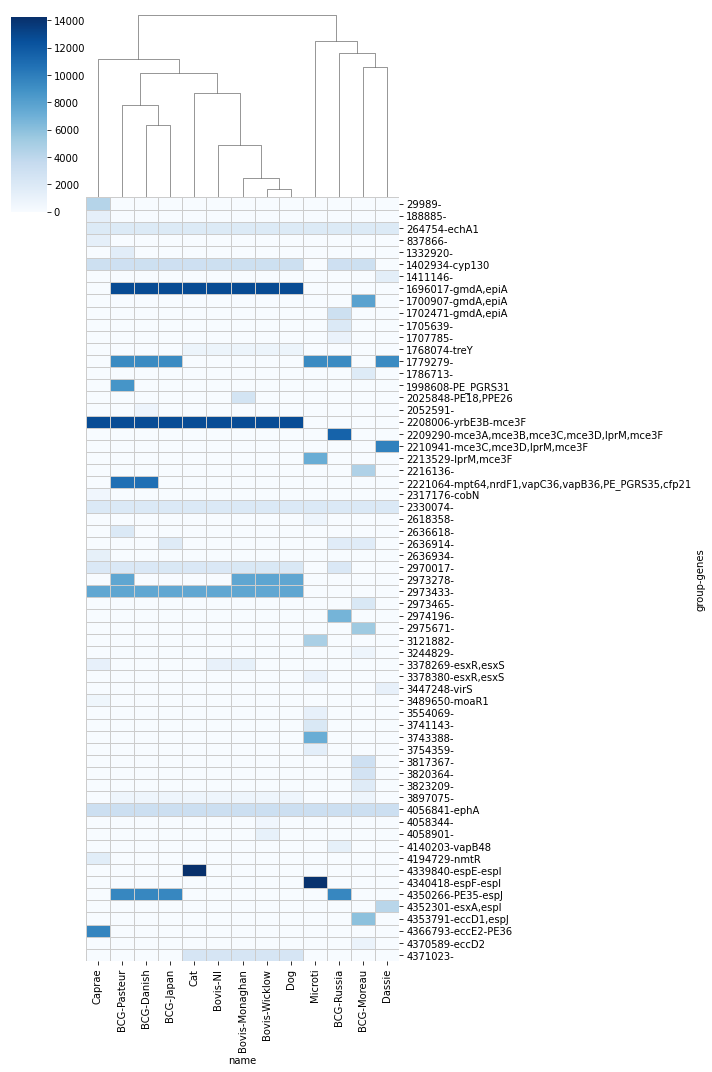

In [29]:
res=regions1[regions1.length>500]
X=pd.pivot_table(res,index=['group','genes'],columns='name',values='length').fillna(0)
#X=X.clip(0,1)
#X=X[X.sum(1)>2]
sns.clustermap(X,cmap='Blues',row_cluster=False,yticklabels=True,lw=1,linecolor='.8',figsize=(10,15))

In [ ]:
reload(rdiff)
s=4339000;e=4390000
rdiff.show_coverage(samples,'NC_000962.3',s,e,app.mtb_genome,app.mtb_gb, minq=0,
                      labelcol='strain',margin=100)

2210941 2220725 9784
2213529 2220725 7196
2216136 2220726 4590
2221064 2231846 10782
2317176 2317723 547
2330074 2332103 2029
2618358 2619067 709
2636618 2638655 2037
2636914 2638653 1739
2636934 2638174 1240


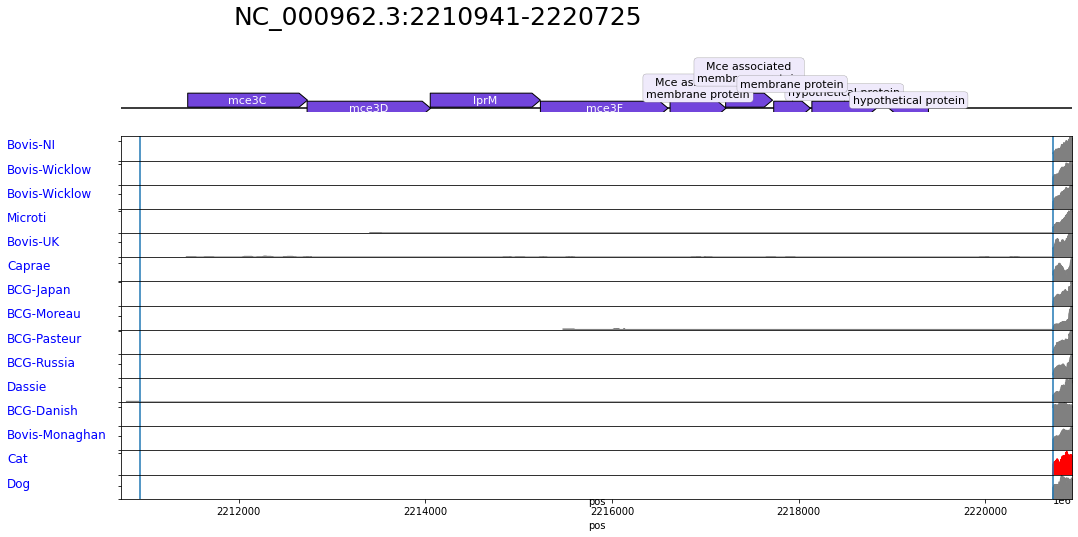

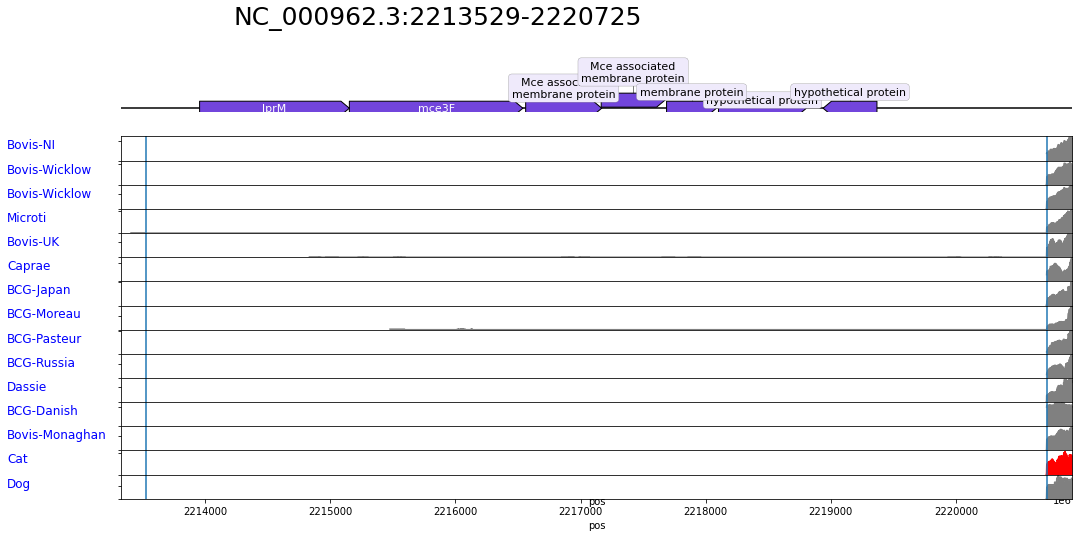

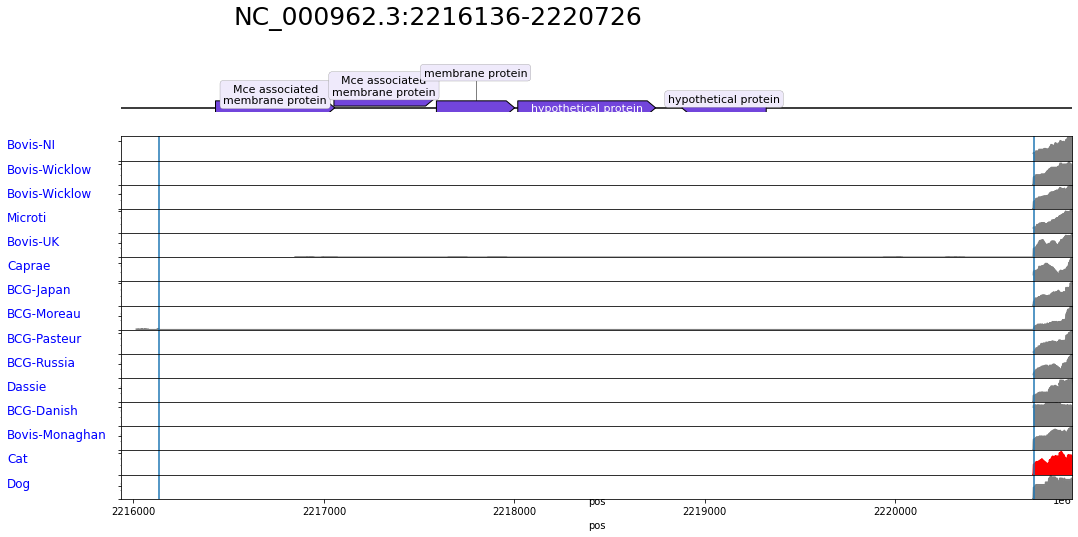

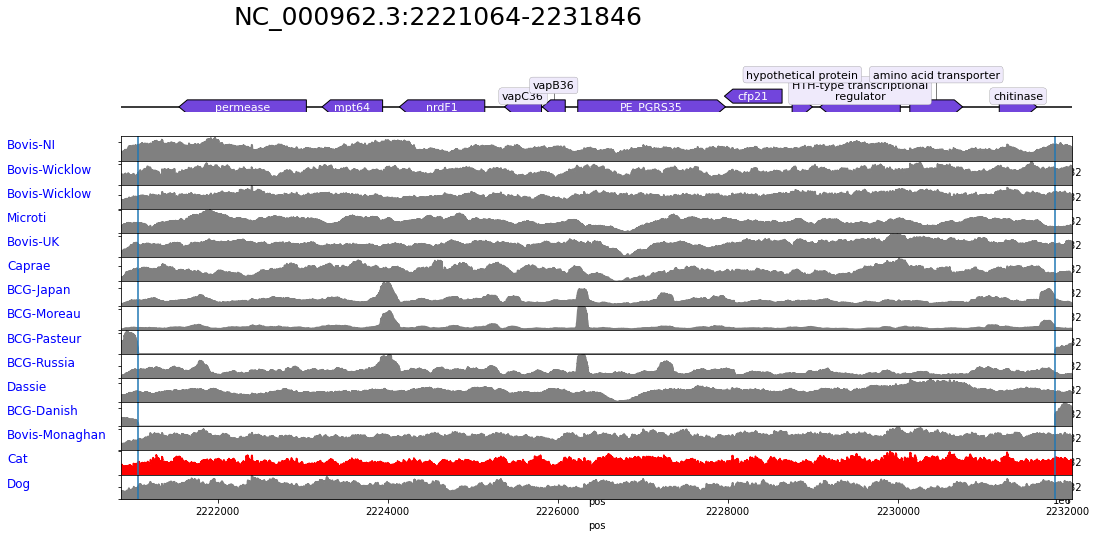

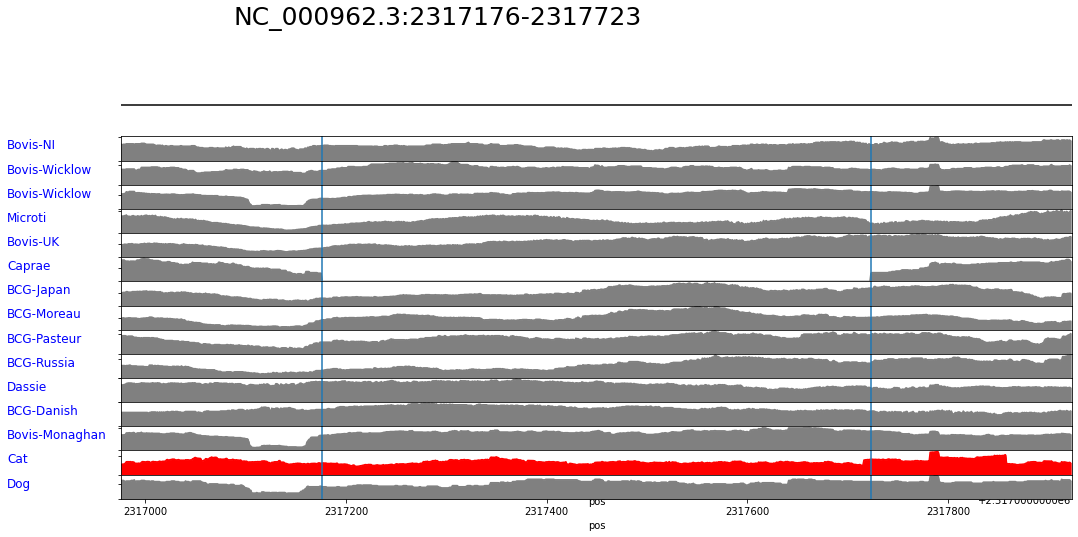

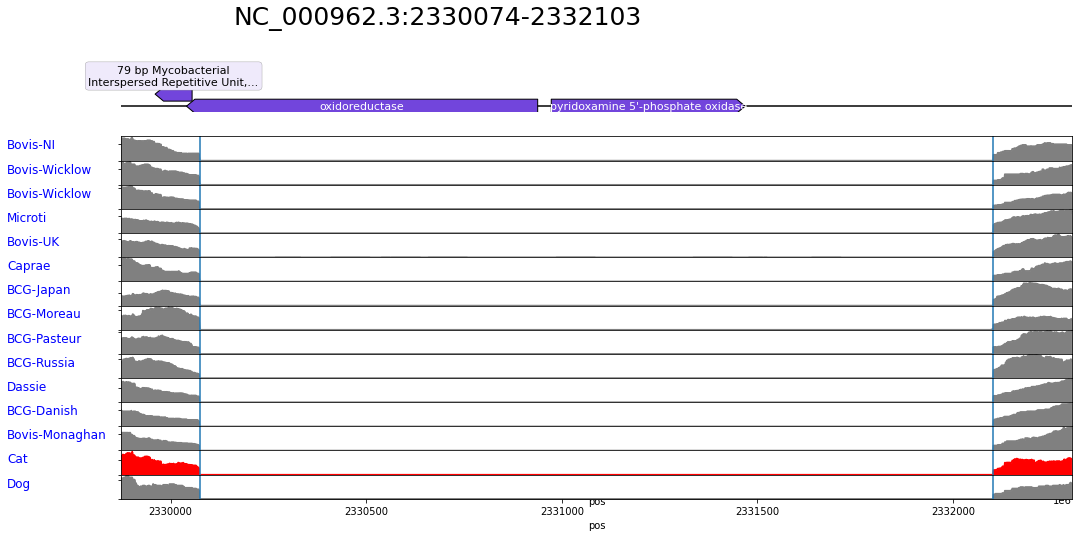

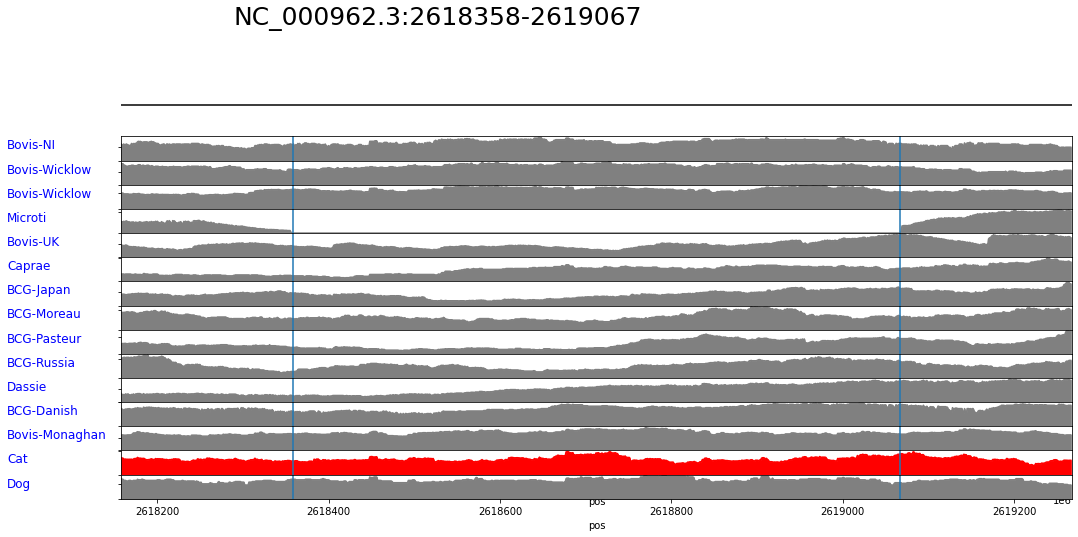

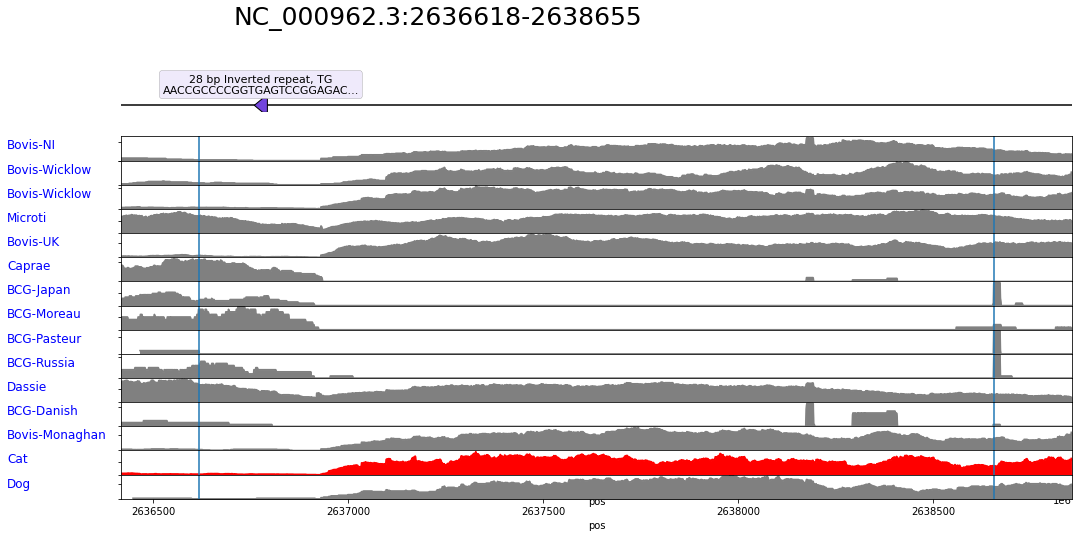

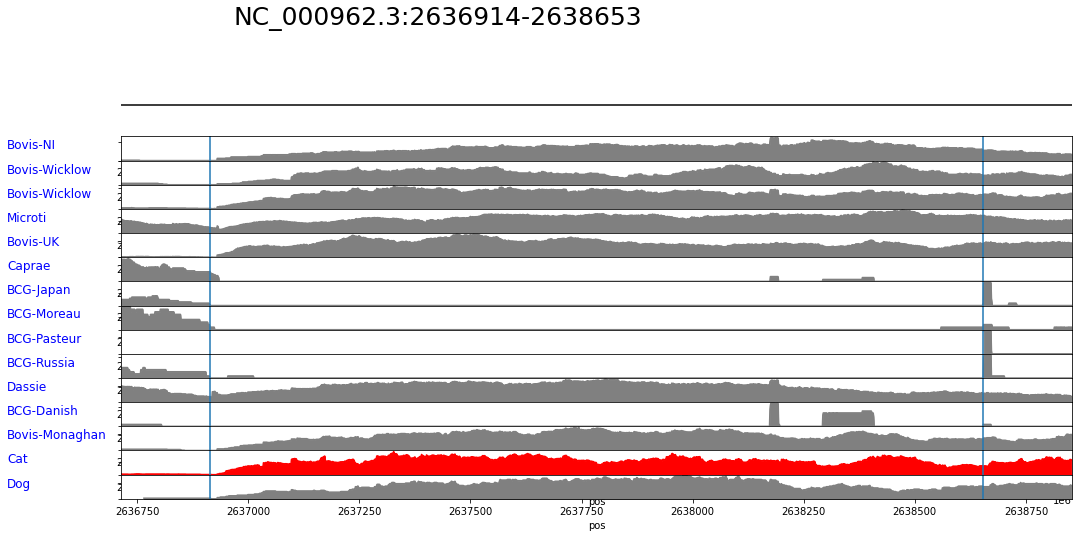

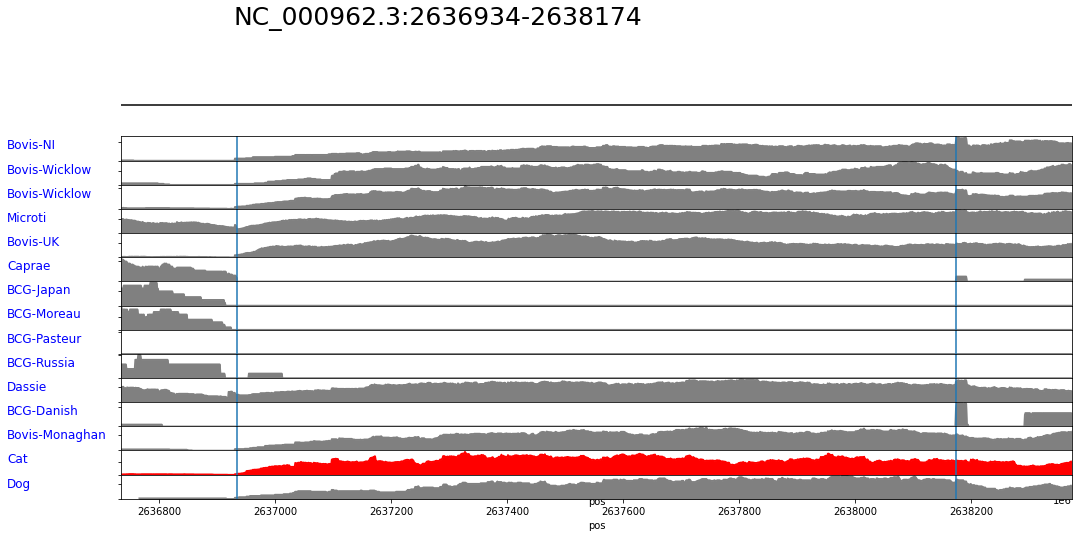

In [30]:
reload(rdiff)
for i,g in list(res.groupby('group'))[20:30]:
    r=g.iloc[0]
    #print (g)
    print (r.start,r.end,r.length)
    rdiff.show_coverage(samples,'NC_000962.3',r.start,r.end,app.mtb_genome,app.mtb_gb,minq=0,
                       colors={'cat-003488':'red'},labelcol='strain',margin=200)

In [ ]:
def spades(f1,f2,out,threads=12):
    cmd = 'spades --pe1-1 {f1} --pe1-2 {f2} --careful -t {t} -o {o}'.format(f1=f1,f2=f2,o=out,t=threads)    
    if not os.path.exists(out): 
        print (cmd)
        subprocess.check_output(cmd, shell=True)
    return

path = 'assembly'
for i,r in samples.iterrows():
    name=r['sample']
    #if name in ['ERR027294','cat-003488']:                
    spades(r.filename1,r.filename2,os.path.join(path,r['sample']))   

In [ ]:
#indels
v=tools.vcf_to_dataframe('results_mtb/indels.vcf.gz')
v['length']=v.end-v.start
#v.sort_values('length')
mat=pd.pivot_table(v,index='sample',columns='start',values='length').T
mat

## use mtbdiff to detect large indels?


In [ ]:
import mtbdiff 

In [ ]:
path = 'assembly'
names = mtbdiff.run_genomes(path, outpath='bovis_diff')

In [ ]:
struct, snp =  mtbdiff.get_nucdiff_results('bovis_diff', names)
struct['RD'] = struct.apply(mtbdiff.get_region,1)
struct=struct[struct.length>10]
struct=struct.merge(meta,left_on='label',right_on='name')

In [ ]:
struct[:5]

In [ ]:
wsamples=['cat-003488','39-Mbovis']
found=struct[(struct.Name=='deletion') & (struct.label.isin(wsamples))]
len(found)

In [ ]:
for i,r in found[30:40].iterrows():
    print (r.start,r.end)
    show_rd_reads('NC_000962.3',r.start,r.end,app.mtb_genome,title=r.descr,colors={'cat-003488':'red'},margin=1000)
    plt.show()

In [ ]:
filt = struct#[struct.region!='PE/PPE']
rdmat = mtbdiff.RD_matrix(filt, columns=['label','strain'])
smat = mtbdiff.sites_matrix(filt, columns=['strain'], freq=2)
print (len(smat))
#smat.to_csv('sites_matrix.csv',index=False)
species = smat.T.index.get_level_values(0)
lut = dict(zip(species.unique(), "rbg"))
row_colors = species.map(lut)

In [ ]:
reload(mtbdiff.analysis)
X=smat.T
cm = mtbdiff.plot_RD(X, width=20,col_cluster=False)

## IGV viewer

https://github.com/igvteam/igv.js/wiki/Tracks-2.0


In [225]:
from igv_jupyterlab import IGV

url = 'http://localhost:8890/files/'

bams={'cat':'results_mtb/mapped/cat-003488.bam',
      'microti':'results_mtb/mapped/ERR027294.bam',
      'mbovis-dog':'results_mtb/mapped/dog-1034.bam'}

track_list = [{"name": "MTB-H37Rv",
                "url": url+"results_mtb/MTB-H37Rv.gb.gff",
                "format": "gff",
                "type": "annotation",
                "height":120,
                "indexed": False }              
             ]

colors=['orange','green','gray']
i=0
for b in bams:
    d = {"name": b,
        "url":url+bams[b],
        "type": "alignment",
         "displayMode":"SQUISHED",
         "height":130,
         "removable":True,
         "color":colors[i],
        "indexed": True }
    track_list.append(d)
    i+=1

genome = IGV.create_genome(
    name="MTB-H37Rv",   
    fasta_url=url+'MTB-H37Rv.fa',
    index_url=url+'MTB-H37Rv.fa.fai',
    tracks=track_list
)

igv = IGV(genome=genome)
igv.locus="NC_000962.3:4338155-4343654"
display(igv)


IGV(id='igv_5951906', initialConfig={'id': 'igv_5951906', 'locus': '', 'reference': {'name': 'MTB-H37Rv', 'fas…